In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Input, Dense, Flatten
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import cv2 as cv
import os 
import glob
import datetime
import time

In [2]:
#CARREGANDO PRÓPRIO DATASET PARA USO

carcionoma_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/carcinoma_in_situ/', '*'))
light_dysplastic_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/light_dysplastic/', '*'))
moderate_dysplastic_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/moderate_dysplastic/', '*'))
normal_columnar_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/normal_columnar/', '*'))
normal_intermediate_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/normal_intermediate/', '*'))
normal_superficiel_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/normal_superficiel/', '*'))
severe_dysplastic_dir = glob.glob(os.path.join('C:/Users/leonardo/Downloads/PDI/severe_dysplastic/', '*'))

x_path = carcionoma_dir + light_dysplastic_dir + moderate_dysplastic_dir + normal_columnar_dir + normal_intermediate_dir + normal_superficiel_dir + severe_dysplastic_dir

x = []

for f in x_path:
    x.append(np.array(cv.resize(cv.imread(f), (32,32), interpolation = cv.INTER_AREA)))

x = np.array(x)
x = x/255

In [3]:
l_carcionoma = np.zeros(len(carcionoma_dir))
l_light_dysplastic = np.ones(len(light_dysplastic_dir))
l_moderate_dysplastic = 2*np.ones(len(moderate_dysplastic_dir))
l_normal_columnar = 3*np.ones(len(normal_columnar_dir))
l_normal_intermediate = 4*np.ones(len(normal_intermediate_dir))
l_normal_superficiel = 5*np.ones(len(normal_superficiel_dir))
l_severe_dysplastic = 6*np.ones(len(severe_dysplastic_dir))

y = np.concatenate((l_carcionoma, l_light_dysplastic, l_moderate_dysplastic, l_normal_columnar, l_normal_intermediate, l_normal_superficiel, l_severe_dysplastic))
y = to_categorical(y, 7)

In [4]:
#TREINAMENTO
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state=42)

In [10]:
#carrega o modelo da VGG16 com os pesos aprendidos no treino da ImageNet sem a camada densa (include_top=False)
VGG = tf.keras.applications.VGG16(input_shape=(32,32,3), include_top = False, weights= 'imagenet')

#congelando os neuronios já treinados na ImageNet, queremos retreinar somente a ultima camada
for layer in VGG.layers:
  layer.trainable = False

model = keras.Sequential([
    VGG,
    Flatten(),
    #adiciona uma camada densa com 256 neuronios com funcao de ativacao relu. 
    Dense(256,activation='relu'),
    #adiciona uma camada densa com 256 neuronios com funcao de ativacao relu. 
    Dense(256,activation='relu'),
    #adiciona os neurônios que devem ser utilizados, nesse caso foram desligados 20% dos neuronios
    Dropout(0.5),
    #adiciona uma camada densa com 7 neuronios (sete classes) com funcao de ativacao softmax (distribuicao de probabilidade)
    Dense(7, activation='softmax')    
])

#definindo modelo final
learning = Adam(lr=0.001)
model.compile(optimizer=learning, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#treinando e testando o modelo
inicio = time.time()
hist = model.fit(x_train, 
                 y_train,
                 batch_size = 32,
                 validation_data = (x_val, y_val),
                 epochs = 50,
                 initial_epoch = 0)
fim = time.time()

Epoch 1/50
46/46 [==============================] - 6s 116ms/step - loss: 1.8640 - accuracy: 0.2503 - val_loss: 1.6499 - val_accuracy: 0.3270
Epoch 2/50
46/46 [==============================] - 7s 144ms/step - loss: 1.5671 - accuracy: 0.3597 - val_loss: 1.4716 - val_accuracy: 0.4360
Epoch 3/50
46/46 [==============================] - 9s 198ms/step - loss: 1.4169 - accuracy: 0.4239 - val_loss: 1.3846 - val_accuracy: 0.4305
Epoch 4/50
46/46 [==============================] - 8s 185ms/step - loss: 1.2873 - accuracy: 0.4693 - val_loss: 1.3787 - val_accuracy: 0.4278
Epoch 5/50
46/46 [==============================] - 9s 188ms/step - loss: 1.2593 - accuracy: 0.5077 - val_loss: 1.3093 - val_accuracy: 0.4687
Epoch 6/50
46/46 [==============================] - 9s 192ms/step - loss: 1.1897 - accuracy: 0.5241 - val_loss: 1.3243 - val_accuracy: 0.4523
Epoch 7/50
46/46 [==============================] - 9s 189ms/step - loss: 1.1499 - accuracy: 0.5355 - val_loss: 1.2930 - val_accuracy: 0.4741
Epoch 

In [12]:
#Média do teste e treino. Também mostra o tempo.
tmp = fim-inicio
loss_train, train_acc = model.evaluate(x_train, y_train, verbose=0)
loss_test, test_acc = model.evaluate(x_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Tempo de treino e teste: ' + str(datetime.timedelta(seconds=tmp)))

Train: 0.994, Test: 0.450
Tempo de treino e teste: 0:07:36.918544


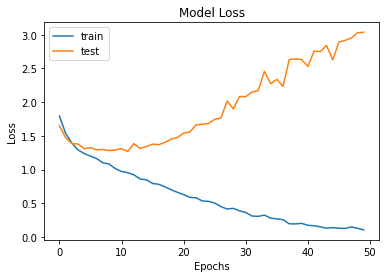

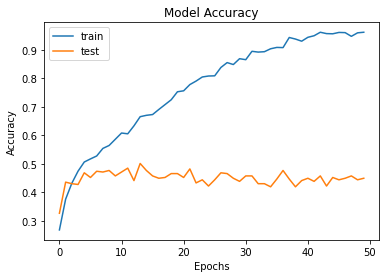

In [13]:
#PLOTANDO GRAFICOS LOSS E ACCURACY
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

----------------CLASSIFICATION--------------
              precision    recall  f1-score   support

           0       0.37      0.64      0.47        53
           1       0.47      0.52      0.49        79
           2       0.41      0.17      0.24        64
           3       0.22      0.21      0.21        34
           4       0.48      0.67      0.56        24
           5       0.84      0.62      0.71        34
           6       0.45      0.41      0.43        79

    accuracy                           0.44       367
   macro avg       0.46      0.46      0.45       367
weighted avg       0.45      0.44      0.43       367

----------------Matrix de Confusão--------------


<AxesSubplot:>

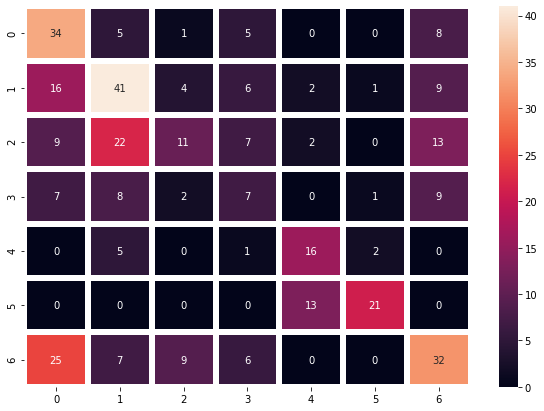

In [14]:
#PLOTANDO MATRIX DE CONFUSÃO
predictions = model.predict(x_val)
y_pred = (predictions > 0.5)
classification = classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print('----------------CLASSIFICATION--------------')
print(classification)
print('----------------Matrix de Confusão--------------')
matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, index = [i for i in range(7)],
                  columns = [i for i in range(7)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, linewidths=5.0)